In [1]:
import matplotlib.pyplot as plt
import numpy as np
import lmfit
import mcmcsim
import corner

In [2]:
def calc_model_line(p, inputs_dict, extra_arg_kw=None):
    x = inputs_dict['x'].values
    y = p['m'] * x + p['b']
    return {
        'y': y,
    }


In [3]:
# np.random.randn(x.size)
# y_true.shape
# y_true_dict['y']

NameError: name 'y_true' is not defined

471.5319311721256
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 59
    # data points      = 1
    # variables        = 2
    chi-square         = 119000.759
    reduced chi-square = 119000.759
    Akaike info crit   = 15.6868852
    Bayesian info crit = 11.6868852
##  Warning: uncertainties could not be estimated:
[[Variables]]
    m:  4.03351547 (init = 4)
    b:  1.81345706 (init = 3)


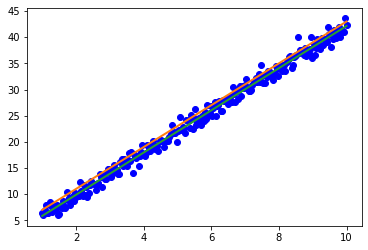

In [5]:
"Creating true parameters and generating fake data"
p_true = lmfit.Parameters()
# p_true.add_many(('m', 3.), ('b', -5.))
p_true.add('m', 4.0, min=-10.0, max=10.0)
p_true.add('b', 2.0, min=-10.0, max=10.0, vary=True)
n_x = 250
sigma = np.full(n_x, 1.0)

x = np.linspace(1, 10, n_x)

inputs_dict = {
    'x': mcmcsim.Variable('x', x),
}

error_y = sigma*np.random.randn(x.size)
y_true_dict = calc_model_line(p_true, inputs_dict)
# y_true = np.column_stack([v for v in y_true_dict.values()])
y_true = y_true_dict['y']
y_exp = y_true + error_y

"Using the dict approach for experimental data and inputs"
y_exp_dict = {
    'y': mcmcsim.Variable('y', y_exp, sigma),
}

"Setting test parameters for estimate"
params0 = lmfit.Parameters()
params0.add('m', 4.0, min=-10.0, max=10.0)
params0.add('b', 3.0, min=-10.0, max=10.0, vary=True)

y_out = calc_model_line(params0, inputs_dict)

"Creating the auxiliary MCMC Runner"
runner = mcmcsim.MCMCRunner(calc_model_line, params0, y_exp_dict, inputs_dict,
    fpath='output_mcmcs.h5', store_outputs=True, store_params_exp_and_inputs=True,
)

"Calculating the (-) log likelihood"
f_ls = runner.calc_minus_loglikelihood(params0)
print(f_ls)

"Regular parameter estimation (using lmfit)"
mini = lmfit.Minimizer(runner.calc_minus_loglikelihood, params0, nan_policy='omit')

out1 = mini.minimize(method='Nelder')
lmfit.report_fit(out1)
params_f = out1.params

"Updating reference parameter in Runner (idealy, it will be passed in the constructor)"
runner.set_parameters_ref(params_f)

"Calculating the outputs using the estimated parameters"
y_out_optimal = calc_model_line(params_f, inputs_dict)

"View"
plt.figure()
plt.plot(x, y_true)
plt.plot(x, y_exp, 'ob', label='exp')
plt.plot(x, y_out['y'], lw=2)
plt.plot(x, y_out_optimal['y'], lw=2)


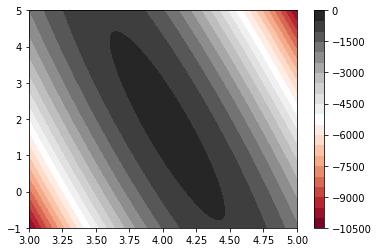

In [14]:
runner.log_probability(params_f)

npts = 101
# a_span = np.linspace(params_f['m'].min, params_f['m'].max, npts)
# b_span = np.linspace(params_f['b'].min, params_f['b'].max, npts)
a_span = np.linspace(3.0, 5, npts)
b_span = np.linspace(-1.0, 5, npts)

AA, BB = np.meshgrid(a_span, b_span)

fvec = np.vectorize(lambda a, b: runner.log_probability_array(np.array([a, b])))
lnPP = fvec(AA, BB)

# lnPP = runner.log_probability_array()
# fvec(params_f['m'].value, params_f['b'].value)
lnPP

plt.contourf(AA, BB, lnPP, 20, cmap='RdGy')
plt.colorbar();

In [7]:
lnPP.shape

(501, 501)

In [ ]:
"First run MCMC"

runner.run_mcmc(load_backend=True, nsteps=1, progress=True)

"Visualizing"

sample_kw = {'thin': 50, 'discard': 100}

"Visualize the outputs"

runner.plot_mcmc_outputs(save_no_show=True, **sample_kw)
print('Image saved to file')

Initial size: 30000


100%|██████████| 1/1 [00:00<00:00, 25.61it/s]


Final size: 30001


In [ ]:
sample_kw = {'thin': 1000, 'discard': 10000}
runner.plot_corner(**sample_kw);

In [15]:
# mcmcsim.display_marginalized_intervals()
mm = runner.get_parameter_interval_from_marginalized(latex_formated=True, **sample_kw)
m_low = mm['m']['median'] - mm['m']['lower']
m_upp = mm['m']['median'] + mm['m']['upper']

b_low = mm['b']['median'] - mm['b']['lower']
b_upp = mm['b']['median'] + mm['b']['upper']


NameError: name 'sample_kw' is not defined